In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [4]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

In [5]:
# merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

# def occurrences(string, sub):
#     count = start = 0
#     while True:
#         start = string.find(sub, start) + 1
#         if start > 0:
#             count+=1
#         else:
#             return count
        
# def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
#     fig, axs = plt.subplots(1,figsize=(12,2.5))
#     ymax= max(max(freq_HL),max(freq_LL))
#     bins = range(0,int(ymax)+1,1)
#     plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
#     plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
#     plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
#     return plt

# def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
#     fig, axs = plt.subplots(1,figsize=(12,2.5))
#     end = 10
#     bins = np.arange(0,end,0.05)
#     plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
#     plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
#     plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
#     return plt

# def run_chi2(seq_of_interest,blocks1,blocks2,consider_if=None):
#     def coo(seq, seq_of_interest):
#         if occurrences("".join(seq),seq_of_interest) >=1:
#             return 1
#         else:
#             return 0
        
#     if consider_if:
#         hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
#         nhl = sum([coo(seq, consider_if) for student,seq in blocks1.iteritems()])-hl
#         ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
#         nll = sum([coo(seq, consider_if) for student,seq in blocks2.iteritems()])-ll
#     else:
#         hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
#         nhl = len(blocks1.keys())-hl
#         ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
#         nll = len(blocks2.keys())-ll
    
#     to_print = [["","Low-High","Low-Low","total"]]
#     to_print.append(["used it",hl,ll,ll+hl])
#     to_print.append(["didn't use it",nhl,nll,nll+nhl])
#     to_print.append(["total",nhl+hl,nll+ll,nll+ll+nhl+hl])
#     print tabulate(to_print)
    
#     total = float(hl + nhl + ll + nll)
#     print 'old: ',stats.chisquare(f_obs= [hl,ll],   # Array of observed counts
#                     f_exp= [(hl+nhl)*(hl+ll)/total,(ll+nll)*(hl+ll)/total])   # Array of expected counts
#     print 'new:', stats.chi2_contingency([[hl,ll],[nhl,nll]], correction=False)
#     return None
# # ### Demonstration of function above
# # b1 = {1:["A","Bo","C","Bo","C","A","C","A"]}
# # b2 = {3:["A","Bo","C","Bo","A","Bo","A","Bo"]}
# # f1,f2 = get_frequencies('BoC',b1,b2,normalize_by='Bo')
# # print f1,f2

# def perform_comparative_stats(seq_of_interest,freq1,freq2):
#     t,p =  stats.ttest_ind(freq1,freq2,equal_var=False)
#     print seq_of_interest,':'
#     print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,4))
#     m,p = stats.mannwhitneyu(freq1,freq2, alternative='less')
#     print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
#     m,p = stats.mannwhitneyu(freq1,freq2, alternative='greater')
#     print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
#     m,p = stats.mannwhitneyu(freq1,freq2, alternative='two-sided')
#     print '\ttwo-sided:\t{0} \t p={1}'.format(round(m,3),round(p,4))

## Overview of analysis
So we want to take a look at what the high prior knowledge are doing. Remember that we have 22 such students, 19 HH and 3 HL. Let's keep the HL and call HH+HL = H*

In [6]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [7]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


We want to compare the three groups to each other. We would like to know if:
- HH look like LL in which case LL use experts strategies that are productive with certain level of prior knowledge
- HH look like LH in which case they used productive strategies

We need to make a new funciton to run the sequence mining with 3 groups.

### Let's make those three groups

In [8]:
def label_3_groups (row):
    if row['split pre']  == 'high':
        return 'H*'
    elif row['split post t2'] == 'high':
        return 'LH'
    else: 
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

for x in ['H*','LH','LL']:
    print x, len(set(df_scores[df_scores['three groups']==x]['student']))

H* 22
LH 38
LL 36


### Let's run the sequence mining like we usually do on all 3 groups

In [12]:
students = get_students()
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 10

### PARAMETERS
attribute = 'three groups'
level1 = 'LH'
level2 = 'LL'
level3 = 'H*'
family_category = "Family"
axis = 1
group_sizes = np.array([len(set(df_scores[df_scores['three groups']==level1]['student'])),len(set(df_scores[df_scores['three groups']==level2]['student'])),len(set(df_scores[df_scores['three groups']==level3]['student']))])


BINS = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          1,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,level3='H*',ignore=['I'])
sequence_counts_group = {s:(counts.T/group_sizes).T for s,counts in sequence_counts_group.iteritems()}
tops = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,level3='H*',ignore=['I'])
sequence_counts_both = {s:counts/group_sizes[:,None] for s,counts in sequence_counts_both.iteritems()}

Getting sequence use over 1 time bins for 96 students split by three groups. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 96 students split by three groups. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


In [30]:
for seq,ig in tops:
    print seq, round(ig,3), np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]

TsPTsPC 0.093 [13.0, 5.0, 7.0]
CTsCTs 0.097 [10.0, 16.0, 4.0]
TbPCP 0.099 [9.0, 6.0, 9.0]
CTbPCP 0.105 [6.0, 5.0, 7.0]
PCTcCP 0.112 [8.0, 13.0, 3.0]
PTsPC 0.112 [20.0, 7.0, 11.0]
PCPTs 0.115 [10.0, 4.0, 7.0]
PCTcCTcC 0.12 [5.0, 13.0, 8.0]
TbPTb 0.126 [7.0, 4.0, 7.0]
TbPCPC 0.13 [5.0, 5.0, 7.0]
TsCTsC 0.145 [6.0, 13.0, 3.0]
PTcCTc 0.152 [18.0, 12.0, 3.0]
CPCTsC 0.254 [5.0, 13.0, 2.0]
TbPCPCP 0.311 [2.0, 5.0, 7.0]
TbPTbC 0.325 [3.0, 3.0, 7.0]


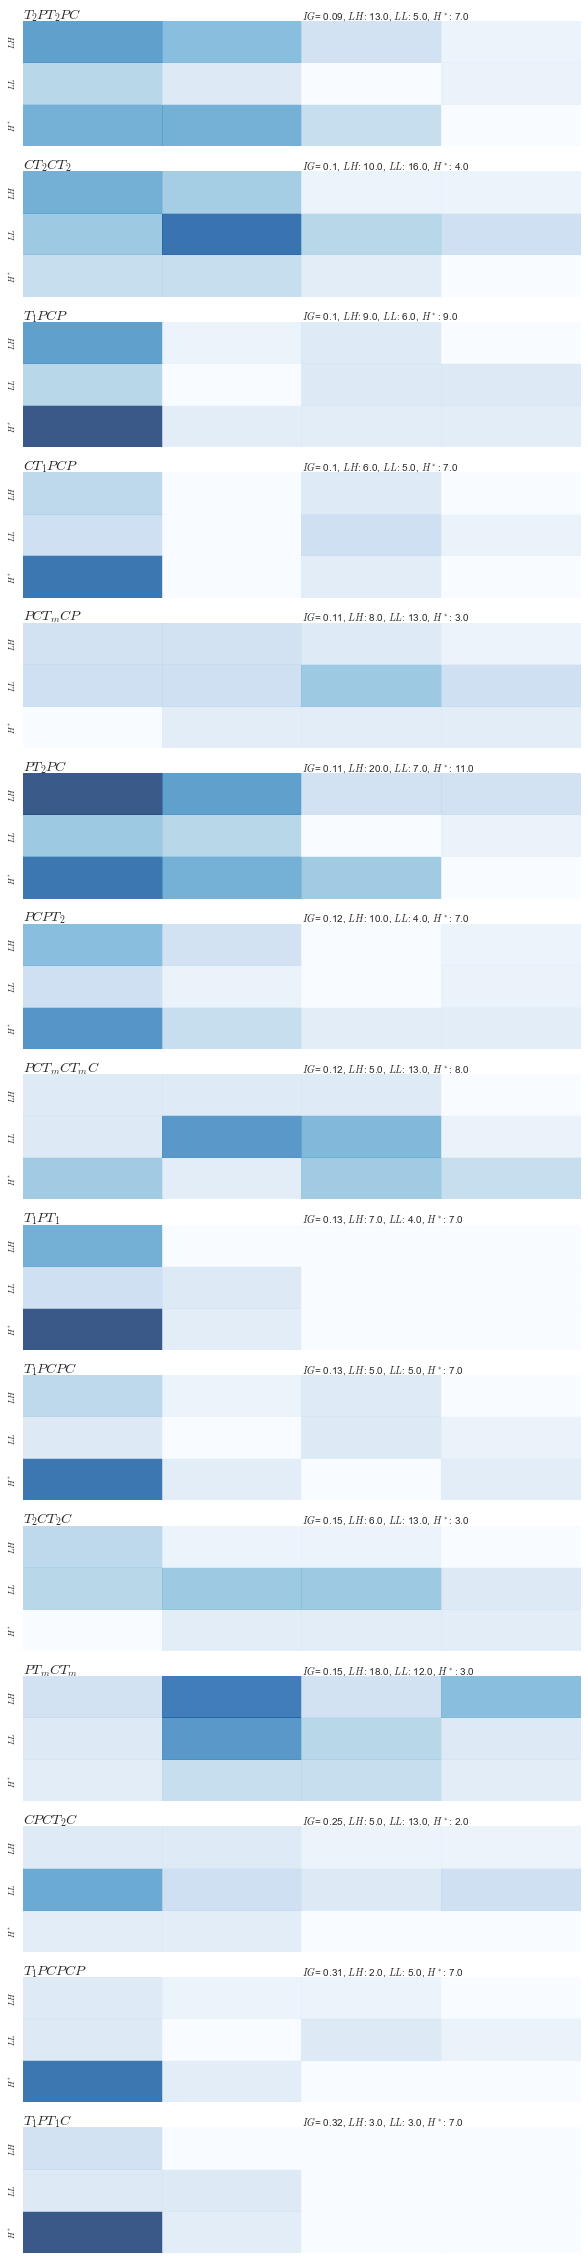

In [33]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])

for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,h_ = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $H^*$: {3}".format(str(round(ig,2)),hl,ll,h_), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,40)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$H^*$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1

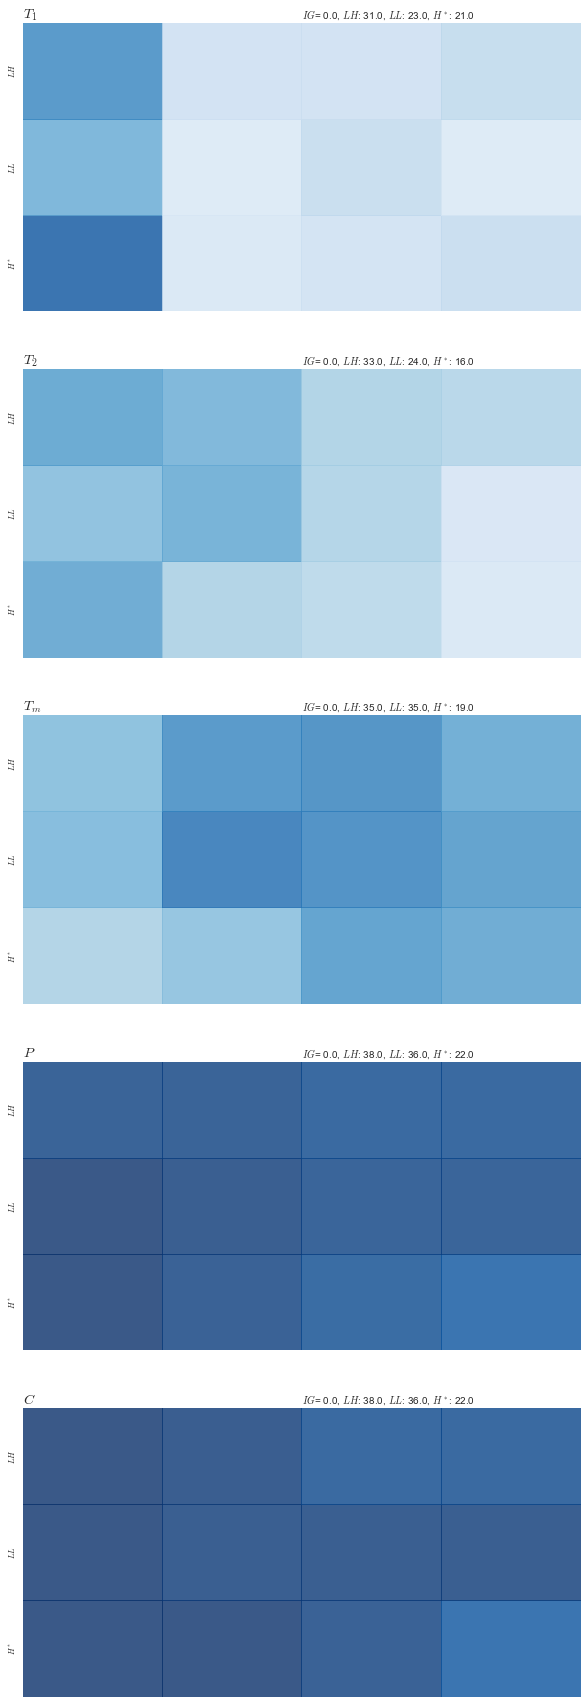

In [34]:
all_actions = [('Tb',0),('Ts',0),('Tc',0),('P',0),('C',0),]
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*all_actions)[0]
fig, axes = plt.subplots(len(all_actions),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs])

for i,(seq,ig) in enumerate(all_actions):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll,h_ = np.ndarray.tolist(sequence_counts_group[seq].T*group_sizes)[0]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,3.05, seq, fontsize=14)
    ax.text(2.0,3.05, "$IG$= {0}, $LH$: {1}, $LL$: {2}, $H^*$: {3}".format(str(round(ig,2)),hl,ll,h_), fontsize=10)
    
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30)
    ax.set_frame_on(False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ylabels = ['$H^*$','$LL$','$LH$']
    ax.set_yticklabels(ylabels)
    ax.set_xticklabels(['','','',''])
        
    i += 1